In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [23]:
df=pd.read_csv('DB_v2.csv',index_col=False)
df=df.drop(['Unnamed: 0'],axis=1)
scaler=StandardScaler()


In [24]:
y=df['DEF_PAY']
X=scaler.fit_transform(df.drop(['DEF_PAY'],axis=1))

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
import joblib

In [26]:
from sklearn.base import BaseEstimator, ClassifierMixin
class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [13]:
def gridSearch(model,params,X,Y,VALID_SIZE,FOLDS=2):
    skf = StratifiedKFold(n_splits=FOLDS)
    scoring = {'AUC': 'roc_auc', 'Accuracy':'accuracy'}    
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=VALID_SIZE, shuffle=True)
    class_weightsTrain = class_weight.compute_class_weight('balanced',np.unique(Y_train),Y_train)
    gs = GridSearchCV(model, scoring=scoring,cv=skf, param_grid=params, return_train_score=True, n_jobs=-1,refit='AUC')
    gs.fit(X_train, Y_train)
    print(gs.best_estimator_)
    print(np.abs(gs.best_score_))
    return gs,X_test,Y_test

In [14]:
kdc=KDEClassifier()
param_grid = {'bandwidth':np.arange(0.05,1,.1)}
gs,_,_=gridSearch(kdc,param_grid,np.array(X),y,0.2)
joblib.dump(gs, 'gs_object.pkl')

ValueError: ignored

In [33]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
import scikitplot as skplt#Esta librería toca instalarla "conda install -c conda-forge scikit-plot"
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE 
def hiper(X,Y,band):
    #Validamos el modelo
    Folds = 10
    skf = StratifiedKFold(n_splits=Folds)
    resultados = pd.DataFrame()
    idx = 0

    for k in band:
      Acc = []
      Auc= []

      for j, (train, test) in enumerate(skf.split(X, Y)):
          Xtrain= X[train,:]
          Ytrain = Y[train]
          Xtest = X[test, :]
          Ytest = Y[test]
          #Normalizamos los datos
          scaler = StandardScaler().fit(X= Xtrain)       
          Xtrain = scaler.transform(Xtrain)
          Xtest = scaler.transform(Xtest)
          model = KDEClassifier(bandwidth=k, kernel='gaussian')
          
          model.fit(X=Xtrain, y=Ytrain)
          Yest = model.predict_proba(Xtest)
          Yest=np.nan_to_num(Yest)
          Acc.append(balanced_accuracy_score(Ytest,np.argmax(Yest, 1)))
          aux=roc_auc_score(Ytest,Yest[:,1])
          Auc.append(aux)
    
      resultados.loc[idx,'BandWith'] = k
      resultados.loc[idx,'AUC medio'] = np.mean(Auc)
      resultados.loc[idx,'AUC intervalo de confianza'] = np.std(Auc)
      resultados.loc[idx,'Accuracy medio'] = np.mean(Acc)
      resultados.loc[idx,'Accuracy intervalo de confianza'] = np.std(Acc)
      idx=idx+1
    
    return (resultados)

def experimentar(X,Y,oversampling=False):
    #Validamos el modelo
    Folds = 2
    skf = StratifiedKFold(n_splits=Folds)
    resultados = pd.DataFrame()
    idx = 0
    Acc = []
    Auc= []

    for j, (train, test) in enumerate(skf.split(X, Y)):
        Xtrain= X[train,:]
        Ytrain = Y[train]
        Xtest = X[test, :]
        Ytest = Y[test]
        #Normalizamos los datos
        scaler = StandardScaler().fit(X= Xtrain)       
        Xtrain = scaler.transform(Xtrain)
        Xtest = scaler.transform(Xtest)
        model = KDEClassifier(bandwidth=0.9555, kernel='gaussian')
        if oversampling:
            sm = SMOTE(random_state=42)
            Xtrain, Ytrain = sm.fit_resample(Xtrain, Ytrain)
        model.fit(X=Xtrain, y=Ytrain)
        Yest = model.predict_proba(Xtest)
        Yest=np.nan_to_num(Yest)
        Acc.append(balanced_accuracy_score(Ytest,np.argmax(Yest, 1)))
        aux=roc_auc_score(Ytest,Yest[:,1])
        Auc.append(aux)
    skplt.metrics.plot_confusion_matrix(Ytest,np.argmax(Yest, 1),normalize=True) #matriz de confusión
    skplt.metrics.plot_roc(Ytest,Yest)
    print(classification_report(Ytest,np.argmax(Yest, 1)))
    
    resultados.loc[idx,'AUC medio'] = np.mean(Auc)
    resultados.loc[idx,'AUC intervalo de confianza'] = np.std(Auc)
    resultados.loc[idx,'Accuracy medio'] = np.mean(Acc)
    resultados.loc[idx,'Accuracy intervalo de confianza'] = np.std(Acc)
    return (resultados)

In [32]:
hiper(X,y,np.arange(0.05,1,.1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6

,BandWith,AUC medio,AUC intervalo de confianza,Accuracy medio,Accuracy intervalo de confianza
0,0.05,0.537081,0.012372,0.533374,0.005154
1,0.15,0.575003,0.012653,0.572527,0.002854
2,0.25,0.614641,0.000849,0.602717,0.001761
3,0.35,0.634007,0.005536,0.612028,0.002724
4,0.45,0.652178,0.001392,0.619193,0.002296
5,0.55,0.674952,0.006718,0.624127,0.004692
6,0.65,0.687269,0.007481,0.625064,0.004528
7,0.75,0.697174,0.007663,0.624702,0.003816
8,0.85,0.708546,0.010051,0.621754,0.004112
9,0.95,0.719078,0.010326,0.616694,0.000128


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


              precision    recall  f1-score   support

           0       0.82      0.95      0.88     11682
           1       0.63      0.28      0.39      3318

    accuracy                           0.80     15000
   macro avg       0.72      0.62      0.63     15000
weighted avg       0.78      0.80      0.77     15000



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


,AUC medio,AUC intervalo de confianza,Accuracy medio,Accuracy intervalo de confianza
0,0.719846,0.009918,0.616317,0.000486


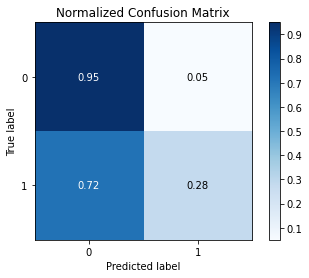

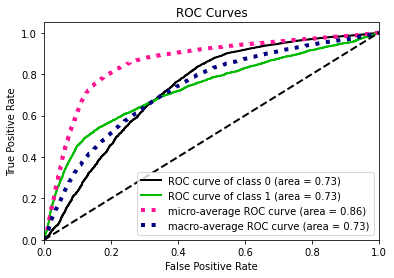

In [34]:
experimentar(X,y,False)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.86      0.80      0.83     11682
           1       0.44      0.56      0.49      3318

    accuracy                           0.75     15000
   macro avg       0.65      0.68      0.66     15000
weighted avg       0.77      0.75      0.76     15000



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


,AUC medio,AUC intervalo de confianza,Accuracy medio,Accuracy intervalo de confianza
0,0.715065,0.009239,0.667799,0.011768


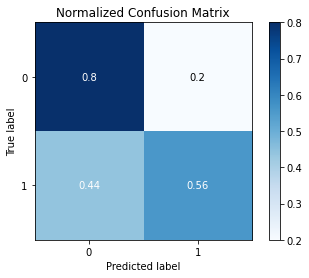

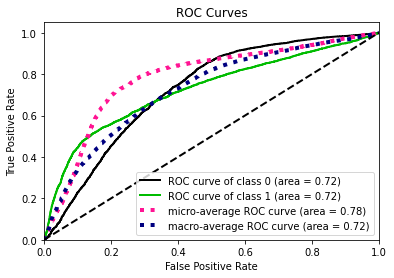

In [35]:
experimentar(X,y,True)